In [5]:
!pip3 install tqdm

In [6]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tqdm import tqdm_notebook
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout

%matplotlib inline
tf.__version__

'2.0.0-rc1'

In [7]:
dataset_path = "/Users/burwani/Downloads/chest_xray/"

In [8]:
# We have 3 datasets: train, validation and test

train_dir = os.path.join(dataset_path, "train")
validation_dir = os.path.join(dataset_path, "val")
test_dir = os.path.join(dataset_path, "test")

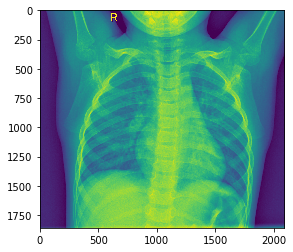

In [9]:
example_img = mpimg.imread(train_dir + "/NORMAL/IM-0115-0001.jpeg")
plt.imshow(example_img)

In [10]:
 def compare_img(subset, labeled = False):
  path = dataset_path + subset
  
  # Taking a random sample from both the PNEUMONIA and the NORMAL directory
  random_pneumonia = np.random.choice(os.listdir(path + "/PNEUMONIA"))
  random_normal = np.random.choice(os.listdir(path + "/NORMAL"))
  
  # Figure size
  fig=plt.figure(figsize=(16, 16))


  # Displaying images
  a = fig.add_subplot(1, 2, 1)
  normal = mpimg.imread(path + "/NORMAL/" + random_normal)
  image1 = plt.imshow(normal)
  
  
  # Option to show the label 
  if labeled:
    a.set_title('NORMAL')
    
  a = fig.add_subplot(1, 2, 2)
  pneumonia = mpimg.imread(path + "/PNEUMONIA/" + random_pneumonia)
  image2 = plt.imshow(pneumonia)
  
  # Option to show the label 
  if labeled:
    a.set_title('PNEUMONIA')
  

  plt.show()

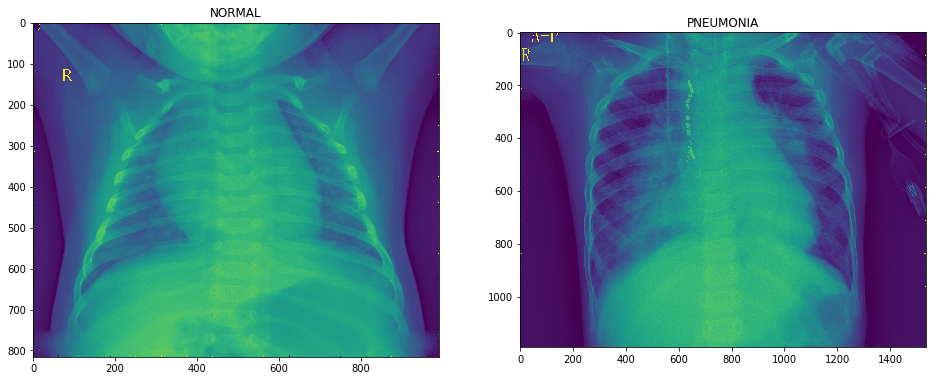

In [11]:
compare_img("train", labeled = True)


# Building the Model

In [12]:
IMG_SHAPE = (150, 150, 3)

In [13]:
base_model = tf.keras.applications.InceptionV3(input_shape = IMG_SHAPE, include_top = False, weights="imagenet")

In [14]:
base_model.trainable = False

In [15]:
base_model.output

<tf.Tensor 'mixed10/Identity:0' shape=(None, 3, 3, 2048) dtype=float32>

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

In [17]:
global_average_layer = Dense(512, activation='relu')(global_average_layer)
global_average_layer = Dropout(0.3)(global_average_layer)
global_average_layer = Dense(256, activation='relu')(global_average_layer)
global_average_layer = Dropout(0.3)(global_average_layer)
global_average_layer = Dense(128, activation='relu')(global_average_layer)
global_average_layer = Dropout(0.3)(global_average_layer)
prediction_layer = tf.keras.layers.Dense(units=2, activation='sigmoid')(global_average_layer)

## Defining the model

In [18]:
model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)

In [19]:

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

## Resizing images

In [20]:
from PIL import Image

In [21]:
data_gen_train = ImageDataGenerator(rescale=1/255.)
data_gen_valid = ImageDataGenerator(rescale=1/255.)

In [22]:
train_generator = data_gen_train.flow_from_directory(train_dir, target_size=(150,150), batch_size=128, class_mode="categorical")

Found 5216 images belonging to 2 classes.


In [23]:
valid_generator = data_gen_valid.flow_from_directory(validation_dir, target_size=(150,150), batch_size=128, class_mode="categorical")

Found 16 images belonging to 2 classes.


In [24]:
test_generator = data_gen_valid.flow_from_directory(test_dir, target_size=(150,150), batch_size=128, class_mode="categorical")

Found 624 images belonging to 2 classes.


In [25]:
model.fit_generator(train_generator, epochs = 5, validation_data = valid_generator)

Epoch 1/5
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
41/41 [==============================] - 351s 9s/step - loss: 0.4840 - accuracy: 0.7868 - val_loss: 1.4793 - val_accuracy: 0.5625
Epoch 2/5
41/41 [==============================] - 363s 9s/step - loss: 0.3151 - accuracy: 0.8775 - val_loss: 1.9566 - val_accuracy: 0.5625
Epoch 3/5
41/41 [==============================] - 351s 9s/step - loss: 0.2607 - accuracy: 0.8978 - val_loss: 1.7458 - val_accuracy: 0.6250
Epoch 4/5
41/41 [==============================] - 348s 8s/step - loss: 0.2400 - accuracy: 0.9066 - val_loss: 2.4966 - val_accuracy: 0.6250
Epoch 5/5
41/41 [==============================] - 359s 9s/step - loss: 0.2156 - accuracy: 0.9172 - val_loss: 1.6847 - val_accuracy: 0.6875


In [26]:
valid_loss, valid_accuracy = model.evaluate_generator(valid_generator)

In [27]:
print("Accuracy after transfer learning: {}".format(valid_accuracy))

Accuracy after transfer learning: 0.6875


## Plotting the results

The below function will compare the true values with the predicted ones using the validation which contains only 16 images (8 for both classes)

Note on model prediction

0 => pneumonia
1 => normal

In [28]:
def compare_results(root_path, generator):

  predictions = model.predict_generator(generator) # Return numpy array of predictions
  class_predicted= [np.argmax(prediction) for prediction in predictions]
  fig = plt.figure(figsize=(24, 18))
  fig.subplots_adjust(hspace=1.5)
  
  normal_path = root_path + '/NORMAL/'
  pneumonia_path = root_path + '/PNEUMONIA/'
  
  normal_dir = os.listdir(normal_path)
  pneumonia_dir = os.listdir(pneumonia_path)
  
  # Generators
  normal_gen =  (x for x in normal_dir if x.endswith('.jpeg'))
  pneumonia_gen =  (y for y in pneumonia_dir if y.endswith('.jpeg'))
  
  for i, normal_file in enumerate(normal_gen):
    img = plt.imread(normal_path + normal_file)
    plt.subplot(4, 4, 1 + i)
    plt.title(f"Prediction: NORMAL\nTrue value: NORMAL" if class_predicted[i] == 1 
              else f"Prediction: PNEUMONIA\nTrue value: NORMAL")
    plt.imshow(img)
    
  for j, pneumonia_file in enumerate(pneumonia_gen):
    img = plt.imread(pneumonia_path + pneumonia_file)
    plt.subplot(4, 4, 9 + j)
    plt.title(f"Prediction: NORMAL\nTrue value: PNEUMONIA" if class_predicted[8+j] == 1 
              else f"Prediction: PNEUMONIA\nTrue value: PNEUMONIA")
    plt.imshow(img)
    

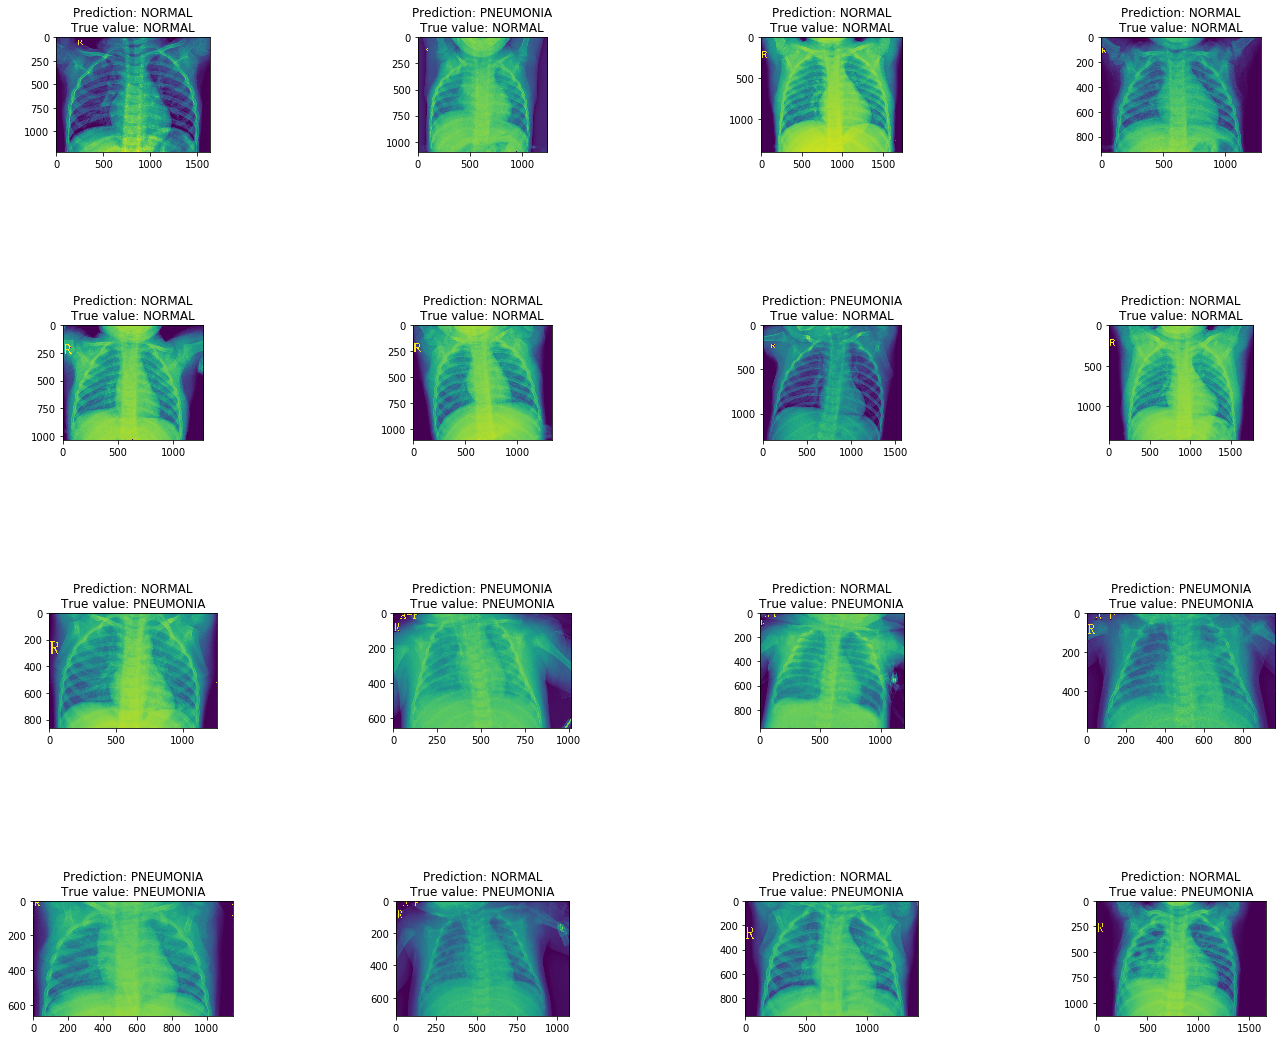

In [29]:
compare_results(validation_dir, valid_generator)

## Saving the model

In [30]:
import json
# serialize model to JSON
model_json = model.to_json()
with open("architecture.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


## Fine Tuning

In [31]:
base_model.trainable = True

In [32]:
print("Number of layers in the base model: {}".format(len(base_model.layers)))

Number of layers in the base model: 311


In [33]:
# Defining the unfreezing starting point
fine_tune_at = 200

In [34]:

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

## Compiling the model for fine tuning

In [35]:

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model.fit_generator(generator = train_generator, epochs = 5, validation_data = valid_generator)

Epoch 1/5
17/41 [===========>..................] - ETA: 3:36 - loss: 0.1860 - accuracy: 0.9258

In [ ]:
valid_loss, valid_accuracy = model.evaluate_generator(valid_generator)
print("Validation accuracy after fine tuning: {}".format(valid_accuracy))
compare_results(validation_dir, valid_generator)